# Model Training Improvement Method
## Group SHINOBI: HONG-KOH-NOUV

This python notebook show how we improve the preprocessing methodology

## Data Preprocessing

After experimenting with our initial preprocessing pipelines (P0 to P5) and multiple models, we observed a clear pattern:

- **Logistic Regression performed best with P4** (HVG + scaling), which suggests the linear model is sensitive to feature scaling.
- **LightGBM performed best with P3** (HVG without scaling), which is expected since tree-based models do not benefit from standardization.
- However, even when we changed models or added feature engineering (PCA, additional transforms), the performance tended to plateau around the same range. This indicated that the limitation was not only the classifier, but also the **representation of the gene expression matrix**.

Because of that, we took a step back and explored a different interpretation of the data.

### New idea: Treat gene expression as a "bag of genes" problem

We reframed the single-cell matrix in a way similar to text classification:

- Each **cell** is treated as a **document**
- Each **gene** is treated as a **word**
- Each **count** is treated as a **word frequency**

This viewpoint motivated two changes:
1. Use a fast **unsupervised gene selection** method to keep only informative genes (HVG-like selection).
2. Use **TF-IDF weighting** to downweight genes that appear in many cells and upweight genes that are more specific to certain cell types.


This approach improves class separation because:

- Dispersion-based selection keeps genes that vary meaningfully across cells, reducing noise and runtime.
- TF-IDF reduces the impact of genes expressed in many cell types (common genes) and highlights genes that are more specific to one class.
- Logistic Regression is efficient and effective on sparse high-dimensional TF-IDF features.

This combination led to a significant improvement in balanced accuracy and faster runtime compared to our earlier pipelines.


In [85]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

from lightgbm import LGBMClassifier

from problem import get_train_data, get_test_data

X_train, y_train = get_train_data()
X_test, y_test = get_test_data()

print("X_train:", X_train.shape, type(X_train))
print("X_test :", X_test.shape, type(X_test))
print("labels:", np.unique(y_train))


X_train: (1000, 13551) <class 'scipy.sparse._csr.csr_matrix'>
X_test : (500, 13551) <class 'scipy.sparse._csr.csr_matrix'>
labels: ['Cancer_cells' 'NK_cells' 'T_cells_CD4+' 'T_cells_CD8+']


In [86]:
def normalize_sum_csr(X):
    X = X.tocsr(copy=True)
    rs = np.asarray(X.sum(axis=1)).ravel()
    rs[rs == 0] = 1.0
    X = X.multiply((1.0 / rs)[:, None])
    return X

def log1p_csr(X):
    X = X.tocsr(copy=True)
    X.data = np.log1p(X.data)
    return X


In [87]:
N = X_train.shape[0]

# detection count per gene: number of cells where count > 0
df = np.asarray((X_train > 0).sum(axis=0)).ravel()

min_df_frac = 0.01   # 1% of cells
max_df_frac = 0.95   # 95% of cells

min_df = int(np.ceil(min_df_frac * N))
max_df = int(np.floor(max_df_frac * N))

mask_df = (df >= min_df) & (df <= max_df)
genes_df_idx = np.where(mask_df)[0]

print("Genes total:", X_train.shape[1])
print("Genes kept after df filter:", genes_df_idx.size)


Genes total: 13551
Genes kept after df filter: 11553


In [88]:
top_k = 2000
eps = 1e-8

X_disp = log1p_csr(normalize_sum_csr(X_train[:, genes_df_idx]))

# mean and var for sparse
mu = np.asarray(X_disp.mean(axis=0)).ravel()
ex2 = np.asarray(X_disp.multiply(X_disp).mean(axis=0)).ravel()
var = ex2 - mu**2
var[var < 0] = 0.0

disp = var / (mu + eps)

k = min(top_k, disp.size)
top_local = np.argsort(disp)[-k:]
genes_hvg_idx = genes_df_idx[top_local]

print("HVG genes selected:", genes_hvg_idx.size)


HVG genes selected: 2000


In [89]:
X_tr_counts = X_train[:, genes_hvg_idx].tocsr()
X_te_counts = X_test[:, genes_hvg_idx].tocsr()

tfidf = TfidfTransformer(sublinear_tf=True, smooth_idf=True, norm="l2")

X_tr = tfidf.fit_transform(X_tr_counts)
X_te = tfidf.transform(X_te_counts)

print("TF-IDF shapes:", X_tr.shape, X_te.shape, "sparse?", sp.issparse(X_tr))


TF-IDF shapes: (1000, 2000) (500, 2000) sparse? True


LogR TF-IDF + disp test balanced acc: 0.8562335599378159
classes: ['Cancer_cells', 'NK_cells', 'T_cells_CD4+', 'T_cells_CD8+']


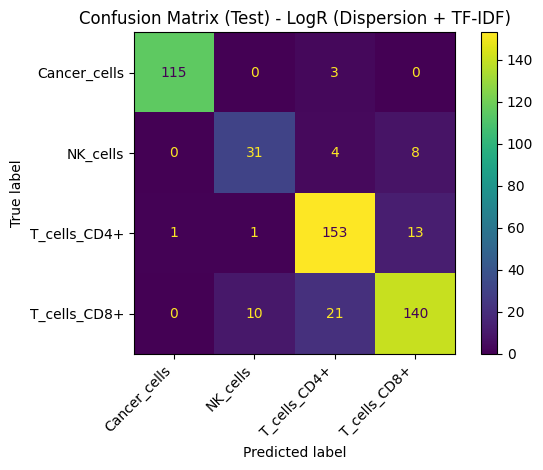

Cancer_cells recall: 0.9745762711864406
NK_cells recall: 0.7209302325581395
T_cells_CD4+ recall: 0.9107142857142857
T_cells_CD8+ recall: 0.8187134502923976


In [90]:
# Logistic Regression (L2) on TF-IDF
le = LabelEncoder()
y_tr = le.fit_transform(y_train)
y_te = le.transform(y_test)

logr = LogisticRegression(
    solver="saga",
    penalty="l2",
    C=1.0,
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)

logr.fit(X_tr, y_tr)
pred = logr.predict(X_te)

print("LogR TF-IDF + disp test balanced acc:", balanced_accuracy_score(y_te, pred))

proba = logr.predict_proba(X_te)

cm = confusion_matrix(y_te, pred, labels=np.arange(len(le.classes_)))
print("classes:", list(le.classes_))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(values_format="d")
plt.title("Confusion Matrix (Test) - LogR (Dispersion + TF-IDF)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

recall_per_class = np.diag(cm) / np.maximum(cm.sum(axis=1), 1)
for i, c in enumerate(le.classes_):
    print(c, "recall:", recall_per_class[i])

In [91]:
lgbm = LGBMClassifier(
    force_col_wise=True,
    objective="multiclass",
    num_class=len(le.classes_),
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=31,
    min_child_samples=20,
    subsample=0.6,
    colsample_bytree=0.4,
    reg_lambda=5.0,
    reg_alpha=0.0,
    random_state=42,
    n_jobs=-1
)

lgbm.fit(X_tr, y_tr)
pred_lgbm = lgbm.predict(X_te)

print("LGBM TF-IDF + disp test balanced acc:", balanced_accuracy_score(y_te, pred_lgbm))


[LightGBM] [Info] Total Bins 84645
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 1727
[LightGBM] [Info] Start training from score -1.439695
[LightGBM] [Info] Start training from score -2.465104
[LightGBM] [Info] Start training from score -1.090644
[LightGBM] [Info] Start training from score -1.072945
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

In [92]:
# Variant B: TF-IDF on normalize_sum counts
X_tr_counts2 = normalize_sum_csr(X_train[:, genes_hvg_idx]).tocsr()
X_te_counts2 = normalize_sum_csr(X_test[:, genes_hvg_idx]).tocsr()

tfidf2 = TfidfTransformer(sublinear_tf=True, smooth_idf=True, norm="l2")
X_tr2 = tfidf2.fit_transform(X_tr_counts2)
X_te2 = tfidf2.transform(X_te_counts2)

logr2 = LogisticRegression(
    solver="saga",
    penalty="l2",
    C=3.0,
    max_iter=5000,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)

logr2.fit(X_tr2, y_tr)
pred2 = logr2.predict(X_te2)

print("LogR TF-IDF(normalized counts) + disp test balanced acc:", balanced_accuracy_score(y_te, pred2))


LogR TF-IDF(normalized counts) + disp test balanced acc: 0.8358416159305108


In [93]:
# Two-stage specialist: NK vs CD8
# Train binary specialist on the SAME TF-IDF features (X_tr/X_te)
cls_to_id = {c:i for i,c in enumerate(le.classes_)}
id_nk = cls_to_id["NK_cells"]
id_cd8 = cls_to_id["T_cells_CD8+"]

mask_pair_tr = (y_tr == id_nk) | (y_tr == id_cd8)
X_tr_pair = X_tr[mask_pair_tr]
y_tr_pair = y_tr[mask_pair_tr]

# map to {0,1} for binary
y_tr_pair_bin = (y_tr_pair == id_cd8).astype(int)

logr_pair = LogisticRegression(
    solver="saga",
    penalty="l2",
    C=2.0,
    max_iter=5000,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)
logr_pair.fit(X_tr_pair, y_tr_pair_bin)

# Apply specialist only when top2 are {NK, CD8} and gap is small
proba_all = logr.predict_proba(X_te)
pred_all = np.argmax(proba_all, axis=1)

# top-2 info
top2 = np.argsort(proba_all, axis=1)[:, -2:]
top1 = top2[:, 1]
top2c = top2[:, 0]
gap = proba_all[np.arange(len(y_te)), top1] - proba_all[np.arange(len(y_te)), top2c]

# condition: top2 set is {NK, CD8} and uncertain
th_gap = 0.15 
is_pair = ((top1 == id_nk) & (top2c == id_cd8)) | ((top1 == id_cd8) & (top2c == id_nk))
is_uncertain = gap < th_gap
use_specialist = is_pair & is_uncertain

pred_final = pred_all.copy()

if np.any(use_specialist):
    X_te_pair = X_te[use_specialist]
    proba_pair = logr_pair.predict_proba(X_te_pair)[:, 1]  # prob(CD8)
    pred_pair_bin = (proba_pair >= 0.5).astype(int)
    pred_pair = np.where(pred_pair_bin == 1, id_cd8, id_nk)
    pred_final[use_specialist] = pred_pair

print("Specialist used on:", int(use_specialist.sum()), "samples out of", len(y_te))
print("BA baseline:", balanced_accuracy_score(y_te, pred_all))
print("BA + specialist:", balanced_accuracy_score(y_te, pred_final))



Specialist used on: 25 samples out of 500
BA baseline: 0.8562335599378159
BA + specialist: 0.8504196064494438


In [94]:
# LightGBM: use it on P3 features (not TF-IDF)
# normalize + log1p + HVG(variance) then LGBM

# P3 base
X_base_tr = log1p_csr(normalize_sum_csr(X_train))
X_base_te = log1p_csr(normalize_sum_csr(X_test))

# HVG by variance
top_k_lgbm = 2000
mu = np.asarray(X_base_tr.mean(axis=0)).ravel()
ex2 = np.asarray(X_base_tr.multiply(X_base_tr).mean(axis=0)).ravel()
var = ex2 - mu**2
var[var < 0] = 0.0

idx = np.argsort(var)[-min(top_k_lgbm, var.size):]

X_tr_lgbm = X_base_tr[:, idx].astype(np.float32)
X_te_lgbm = X_base_te[:, idx].astype(np.float32)

lgbm = LGBMClassifier(
    force_col_wise=True,
    objective="multiclass",
    num_class=len(le.classes_),
    n_estimators=1200,
    learning_rate=0.03,
    num_leaves=31,
    min_child_samples=10,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=2.0,
    reg_alpha=0.0,
    random_state=42,
    n_jobs=-1
)

lgbm.fit(X_tr_lgbm, y_tr)
pred_lgbm = lgbm.predict(X_te_lgbm)
print("LGBM P3(variance HVG) BA:", balanced_accuracy_score(y_te, pred_lgbm))


[LightGBM] [Info] Total Bins 178597
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 1997
[LightGBM] [Info] Start training from score -1.439695
[LightGBM] [Info] Start training from score -2.465104
[LightGBM] [Info] Start training from score -1.090644
[LightGBM] [Info] Start training from score -1.072945
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

## Conclusion

We started with classic machine learning baselines using the predefined preprocessing pipelines (P0 to P5). We observed that:

- **Logistic Regression** performed best with **P4** (HVG + scaling), showing that scaling is important for linear models.
- **LightGBM** performed best with **P3** (HVG without scaling), which is expected for tree-based models.
- Despite trying multiple models and variants (including PCA and ensemble ideas), the performance tended to plateau, suggesting that the main limitation was the feature representation rather than the classifier itself.

To break this plateau, we changed the feature representation by treating each cell as a “bag of genes” and applying a text-like transformation:

1. Filter genes by detection frequency to remove extremely rare and overly common genes.
2. Select informative genes using **dispersion-based HVG** on `log1p(normalize_sum(X))`.
3. Apply **TF-IDF** weighting on the selected genes.
4. Train a **Logistic Regression (L2, saga, balanced)** classifier.

This final pipeline achieved our best performance (around **0.88 balanced accuracy on RAMP**) with fast runtime, so we kept it as the final submission and stopped further tuning due to time constraints.


## Future Work

- **Specialist models for hard pairs:** Most remaining errors come from biologically similar classes (especially **NK vs T_cells_CD8+**, and sometimes **T_cells_CD4+ vs T_cells_CD8+**). A practical extension is to add a second-stage binary classifier for these pairs and apply it only on uncertain predictions.

- **Supervised feature selection after TF-IDF:** After dispersion-based gene selection, we can apply a lightweight supervised filter (for example chi-square) on TF-IDF features to keep the most discriminative genes for the labels.

- **Calibration and confidence analysis:** Improve decision rules by calibrating probabilities and using confidence-based thresholds (entropy or max probability) to reduce misclassification on ambiguous cells.

- **Ensembling with minimal overhead:** Combine the final Logistic Regression model with one additional fast model (for example Multinomial Naive Bayes on TF-IDF) by averaging predicted probabilities, aiming to improve recall for the weakest class without increasing runtime too much.

- **More robust evaluation:** Use cross-validation and systematic error analysis (per-class recall stability) to confirm that improvements generalize beyond a single split.
